## Plot returns for best trained PPO models

1. evaluate top 3 models selected using validation data, each for 10 times in the test environment with different seeds.
2. evaluate bottom 3 models selected using validation data, each for 10 times in the test environment with different seeds.

In [2]:
pip install tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.8/183.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.3/400.3 kB 9.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [52]:
import gymnasium as gym
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from src.env.environment import StockEnvTrade
from src.utils.common_utils import DRL_prediction, make_env_test, Agent

import warnings
warnings.filterwarnings("ignore")

df_test = pd.read_csv("data/yahoo_finance_test.csv")

TOP_THREE_PPO_MODELS = ["example_models/ppo/top/hyperparam_257/run3/torch_ppo.pt", #2.921354 val data performance
                    "example_models/ppo/top/hyperparam_11/run2/torch_ppo.pt",  #2.778794
                    "example_models/ppo/top/hyperparam_269/run1/torch_ppo.pt" #2.588476
                    ]

BOTTOM_THREE_PPO_MODELS = ["example_models/ppo/bottom/hyperparam_253/run0/torch_ppo.pt", #0.864143
                       "example_models/ppo/bottom/hyperparam_233/run1/torch_ppo.pt", #0.838111	
                       "example_models/ppo/bottom/hyperparam_193/run0/torch_ppo.pt" #0.791893	
                       ]

TOP_THREE_A2C_MODELS = ["example_models/a2c/top/hyperparam_239/run3/torch_a2c.pt",#3.591392
                    "example_models/a2c/top/hyperparam_199/run0/torch_a2c.pt", #2.796911
                    "example_models/a2c/top/hyperparam_105/run1/torch_a2c.pt" #2.663316
                    ]

BOTTOM_THREE_A2C_MODELS = ["example_models/a2c/bottom/hyperparam_270/run1/torch_a2c.pt", #0.860622
                       "example_models/a2c/bottom/hyperparam_238/run0/torch_a2c.pt",#0.816576	
                       "example_models/a2c/bottom/hyperparam_258/run1/torch_a2c.pt",#0.795069
                       ]


N_RUNS = 10 #evaluate 10 times

def compute_returns(model_path: str, seed:int=None):

    #initialize test environment
    stock_env_trade = StockEnvTrade(df = df_test)
    test_env = gym.vector.SyncVectorEnv(
            [make_env_test(env_ = stock_env_trade, seed = seed) for i in range(1)]
        )

    model = Agent(envs=test_env, 
                input_dims=np.array(test_env.observation_space.shape).prod(),
                output_dims=np.prod(test_env.action_space.shape))
    model.load_state_dict(torch.load(model_path))

    #reset test env
    test_obs, _ = test_env.reset()

    portfolio_weights = np.array(DRL_prediction(df_test, model, test_env, test_obs))
    #print(portfolio_weights_ppo.shape) (353, 8)

    return_stocks = df_test.pct_change()
    return_stocks = np.sum(return_stocks.multiply(portfolio_weights), axis=1)
    cumulative_returns_daily_drl = (1+return_stocks).cumprod()

    return portfolio_weights, cumulative_returns_daily_drl

In [69]:

res = []
for model_path in [TOP_THREE_PPO_MODELS[2]]:
    for run in range(N_RUNS):
        portfolio_weights, cum_return = compute_returns(model_path, seed=1)
        res.append(cum_return.iloc[-1])
print(res)
print(np.mean(res))

[1.8134240411160556, 1.9111030112595317, 1.8869348146597156, 1.8158809979234827, 1.804166198301727, 1.8577289072146068, 1.8643259551821045, 1.8715553466692145, 1.6706666322323216, 1.9202747550785593]
1.841606065963732


In [70]:
res = []
for model_path in [TOP_THREE_A2C_MODELS[2]]:
    for run in range(N_RUNS):
        portfolio_weights1, cum_return1 = compute_returns(model_path, seed=1)
        res.append(cum_return.iloc[-1])
print(res)
print(np.mean(res))

[1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593, 1.9202747550785593]
1.9202747550785593


Weight Distribution of PPO Top1

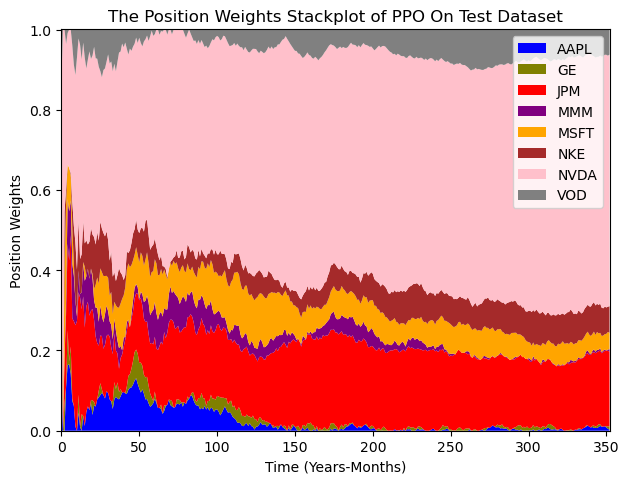

In [71]:
df = pd.DataFrame(portfolio_weights,  columns=df_test.columns)

# Define custom colors for each stock
colors = ['blue', 'olive', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']


# Stackplot with custom colors
plt.stackplot(df_test.index, df.values.T, labels=df_test.columns, colors=colors)

# Other customization
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")
plt.ylabel("Position Weights")
plt.tight_layout()
plt.title("The Position Weights Stackplot of PPO On Test Dataset")


# Show the plot
plt.show()


Weight Distribution of A2C Top1

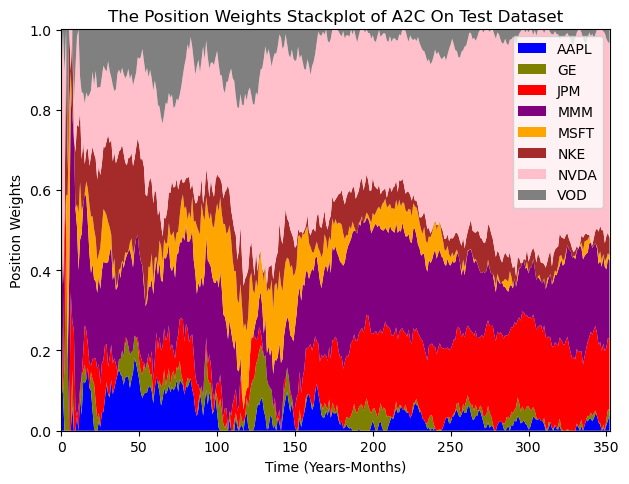

In [72]:
df = pd.DataFrame(portfolio_weights1,  columns=df_test.columns)

# Define custom colors for each stock
colors = ['blue', 'olive', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Stackplot with custom colors
plt.stackplot(df_test.index, df.values.T, labels=df_test.columns, colors=colors)

# Other customization
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")
plt.ylabel("Position Weights")
plt.tight_layout()
plt.title("The Position Weights Stackplot of A2C On Test Dataset")


# Show the plot
plt.show()

Baseline


In [102]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import riskfolio as rp
import yfinance as yf
import warnings
import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions

Data Retreiving for baselines

In [103]:
# Date range
start = '2010-01-01'
end = '2018-05-30'

# Tickers of assets
assets = ['AAPL', 'GE', 'JPM', 'MMM', 'MSFT', 'NKE', 'NVDA', 'VOD']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

#train:test = 8:2
train_len = int(0.8*len(data))
train_df = data[:train_len]
test_df = data[train_len:]

[*********************100%%**********************]  8 of 8 completed


Baseline 1 Mean-Variance Markowitz Model

In [104]:
window = 20

tickers = data.columns

#history span
portfolio_weights_min_var = np.zeros([data.shape[0]-window, len(tickers)])

idx=0
for i in range(window,len(data)):    
    sel = data.iloc[i-window:i]
    #mean
    mu = expected_returns.mean_historical_return(sel)
    #variance
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_min_var[idx]=np.array([weights[j] for j in tickers])
    idx +=1

In [105]:
test_df

,AAPL,GE,JPM,MMM,MSFT,NKE,NVDA,VOD
Date,,,,,,,,
2016-09-22,26.531513,165.273773,54.947323,139.096329,52.438351,51.194126,15.998898,17.931154
2016-09-23,26.089397,164.448486,54.833164,137.193787,52.084660,50.953888,15.981669,17.640671
2016-09-26,26.128748,162.522858,53.634575,136.080063,51.603985,50.260963,15.831574,17.592258
2016-09-27,26.177355,164.393463,54.107494,136.350754,52.556255,51.129444,16.372915,17.713289
2016-09-28,26.376427,164.503510,54.392864,137.348480,52.628799,49.198452,16.431965,17.846434
...,...,...,...,...,...,...,...,...
2018-05-22,44.597000,88.338829,95.910248,160.532608,91.834084,67.207344,60.078773,17.597353
2018-05-23,44.882931,81.925728,95.468910,160.290573,92.926666,67.235611,61.314785,17.368731
2018-05-24,44.832893,84.352303,94.399590,160.887604,92.596992,68.027275,61.351944,17.179302


In [106]:
return_stocks = test_df.pct_change()
return_stocks_min_var = np.sum(return_stocks.multiply(portfolio_weights_min_var[train_len-window:]),axis=1)
cumulative_returns_daily_min_var = (1+return_stocks_min_var).cumprod()

Baseline 2 Sharpe-CVaR

In [107]:
# Calculating returns

Y = data[assets].pct_change().dropna()

total_Y = Y
window = 100
tickers = data.columns

portfolio_weights_cvar = np.zeros([data.shape[0]-window, len(tickers)])

idx=0
sub_count = 0
for i in range(window,len(data)): 
    
    #rolling window
    Y = total_Y[i-window:i]
    # Building the portfolio object
    port = rp.Portfolio(returns=Y)


    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:
    # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    # Risk measure used, this time will be CVaR
    # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    # Use historical scenarios for risk measures that depend on scenarios
    # Risk free rate
    # Risk aversion factor, only useful when obj is 'Utility'

    params = {'model': 'Classic', 'rm': 'CVaR', 'obj': 'Sharpe', 'hist': True, 'rf': 0, 'l': 0}

    w = port.optimization(**params)

    try:
        portfolio_weights_cvar[idx] = np.array([w.T[j][0] for j in tickers])
    except:
        # if the problem doesn't have a solution at a specific time, you can use the one from last period
        portfolio_weights_cvar[idx] = portfolio_weights_cvar[idx-1]
        sub_count+=1
        
    idx+=1
    

# display(w.T)

In [135]:

for model_path in [TOP_THREE_PPO_MODELS[0]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoTop1 = np.mean(cum_return,axis=0)

In [108]:
return_stocks = test_df.pct_change()
return_stocks_cvar = np.sum(return_stocks.multiply(portfolio_weights_cvar[train_len-window:]),axis=1)
cumulative_returns_daily_cvar = (1+return_stocks_cvar).cumprod()

In [ ]:

for model_path in [TOP_THREE_PPO_MODELS[0]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoTop1 = np.mean(cum_return,axis=0)
    
for model_path in [TOP_THREE_PPO_MODELS[1]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r =  compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoTop2 = np.mean(cum_return,axis=0)

for model_path in [TOP_THREE_PPO_MODELS[2]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r =  compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoTop3 = np.mean(cum_return,axis=0)


for model_path in [BOTTOM_THREE_PPO_MODELS[0]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoBottom1 = np.mean(cum_return,axis=0)

for model_path in [BOTTOM_THREE_PPO_MODELS[1]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoBottom2 = np.mean(cum_return,axis=0)


for model_path in [BOTTOM_THREE_PPO_MODELS[2]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    ppoBottom3 = np.mean(cum_return,axis=0)
   


for model_path in [TOP_THREE_A2C_MODELS[0]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cTop1 = np.mean(cum_return,axis=0)

for model_path in [TOP_THREE_A2C_MODELS[1]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cTop2 = np.mean(cum_return,axis=0)

for model_path in [TOP_THREE_A2C_MODELS[2]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cTop3 = np.mean(cum_return,axis=0)


for model_path in [BOTTOM_THREE_A2C_MODELS[0]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cBottom1 = np.mean(cum_return,axis=0)

for model_path in [BOTTOM_THREE_A2C_MODELS[1]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cBottom2 = np.mean(cum_return,axis=0)


for model_path in [BOTTOM_THREE_A2C_MODELS[2]]:
    cum_return = []
    for run in range(N_RUNS):
        _,temp_r = compute_returns(model_path, seed=1)
        cum_return.append(temp_r)
    a2cBottom3 = np.mean(cum_return,axis=0)

        
cvar = cumulative_returns_daily_cvar[-len(ppoTop1):]
meanV = cumulative_returns_daily_min_var[-len(ppoTop1):]
cvar = cvar/cvar[0]
meanV = meanV/meanV[0]



In [141]:
def SeriesTransform(arr):
    df = pd.DataFrame(arr)
    df.index = cvar.index
    series = pd.Series(df.iloc[:,0])
    return series

ppoTop1 =  SeriesTransform(ppoTop1)
ppoTop2 =  SeriesTransform(ppoTop2)
ppoTop3 =  SeriesTransform(ppoTop3)
ppoBottom1 =  SeriesTransform(ppoBottom1)
ppoBottom2 =  SeriesTransform(ppoBottom2)
ppoBottom3 =  SeriesTransform(ppoBottom3)


a2cTop1 =  SeriesTransform(a2cTop1)
a2cTop2 =  SeriesTransform(a2cTop2)
a2cTop3 =  SeriesTransform(a2cTop3)
a2cBottom1 =  SeriesTransform(a2cBottom1)
a2cBottom2 =  SeriesTransform(a2cBottom2)
a2cBottom3 =  SeriesTransform(a2cBottom3)

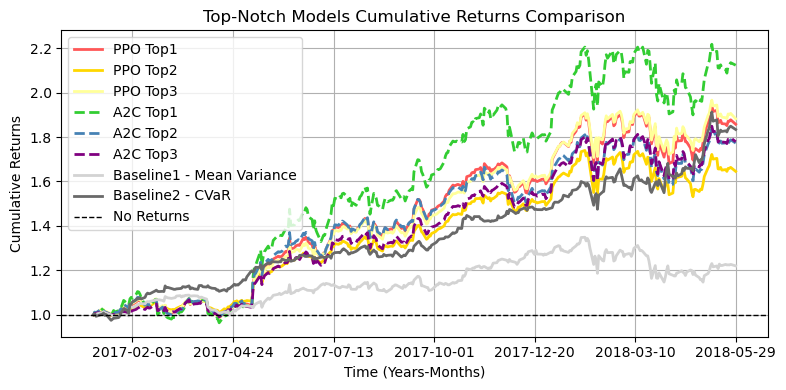

<Figure size 640x480 with 0 Axes>

In [146]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,4))

# Plot cumulative returns with specific colors and linestyles for PPO
ax.plot(ppoTop1, label='PPO Top1', color='#FF5757', linestyle='-', lw=2)  # 红色
ax.plot(ppoTop2, label='PPO Top2', color='#FFD700', linestyle='-', lw=2)  # 金色
ax.plot(ppoTop3, label='PPO Top3', color='#FFFF99', linestyle='-', lw=2)  # 浅黄色

# Plot cumulative returns with specific colors and linestyles for A2C
ax.plot(a2cTop1, label='A2C Top1', color='#32CD32', linestyle='--', lw=2)  # 酸橙绿
ax.plot(a2cTop2, label='A2C Top2', color='#4682B4', linestyle='--', lw=2)  # 钢蓝色
ax.plot(a2cTop3, label='A2C Top3', color='#800080', linestyle='--', lw=2)  # 深紫色

# Plot cumulative returns with specific colors and linestyles for Baseline 1
ax.plot(meanV, label='Baseline1 - Mean Variance', color='#D3D3D3', linestyle='-', lw=2)  # 蓝紫色

# Plot cumulative returns with specific colors and linestyles for Baseline 2
ax.plot(cvar, label='Baseline2 - CVaR', color='#696969', linestyle='-', lw=2)  # 暗灰色

# Add a horizontal line at y=1
ax.axhline(1, color='black', linestyle='--', lw=1, label='No Returns')

# Add labels and title
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
ax.set_title("Top-Notch Models Cumulative Returns Comparison")

# Add a legend
ax.legend()

# Format x-axis labels as dates (modify as needed based on your date format)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))  # Set maximum number of x-axis ticks

# Add grid lines
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Add a horizontal line at y=1
ax.axhline(1, color='black', linestyle='--', lw=1, label='No Returns')

# Add labels and title
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
ax.set_title("Top-Notch Parameters Cumulative Returns Comparison")

# Add a legend
ax.legend()

# Format x-axis labels as dates (modify as needed based on your date format)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))  # Set maximum number of x-axis ticks

# Add grid lines
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

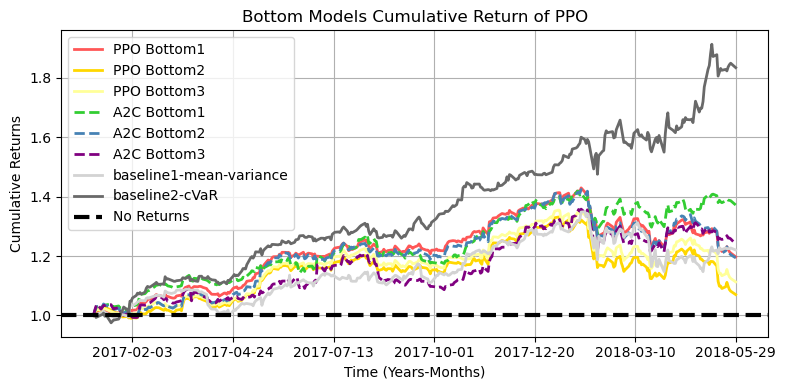

In [147]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot cumulative returns with a specific color and linestyle
ax.plot(ppoBottom1, label='PPO Bottom1', color='#FF5757', linestyle='-', lw=2)
ax.plot(ppoBottom2, label='PPO Bottom2', color='#FFD700', linestyle='-', lw=2)
ax.plot(ppoBottom3, label='PPO Bottom3', color='#FFFF99', linestyle='-', lw=2)

ax.plot(a2cBottom1, label='A2C Bottom1', color='#32CD32', linestyle='--', lw=2)
ax.plot(a2cBottom2, label='A2C Bottom2', color='#4682B4', linestyle='--', lw=2)
ax.plot(a2cBottom3, label='A2C Bottom3', color='#800080', linestyle='--', lw=2)

ax.plot(meanV, label='baseline1-mean-variance', color='#D3D3D3', linestyle='-', lw=2)
ax.plot(cvar, label='baseline2-cVaR', color='#696969', linestyle='-', lw=2)

# Add a horizontal line at y=1
ax.axhline(1, color='black', linestyle='--', lw=3, label='No Returns')

# Add labels and title
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
ax.set_title("Bottom Models Cumulative Return of PPO")

# Add a legend
ax.legend()

# Format x-axis labels as dates (modify as needed based on your date format)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))  # Set maximum number of x-axis ticks


# Add grid lines
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [156]:
def MaxDrawDown(cumulative_return):
    maxdraw = -np.inf
    for i in range(len(cumulative_return)-1):
        temp_max = -np.inf
        for j in range(i+1,len(cumulative_return)):
            if cumulative_return[j]<cumulative_return[i]:
                temp_max = max(temp_max,1-cumulative_return[j]/cumulative_return[i])
            else:
                maxdraw = max(maxdraw,temp_max)
                break
    return maxdraw


def AnnualReturn(cumulative_return):
    days_in_test = (cumulative_return.index[-1] - cumulative_return.index[0]).days
    days_per_year = 252
    
    annualReturn = cumulative_return[-1]**(days_per_year/days_in_test)-1
    
    return annualReturn
    

def AnnualVolatility(cumulative_return):
    
    daily_ret = cumulative_return.pct_change()
    daily_ret.dropna(inplace=True)
    ret_std = daily_ret.std()
    annualVolatility = ret_std*np.sqrt(252)
    return annualVolatility


def Calmar(annualReturn,maxdrawDown):
    return annualReturn/maxdrawDown

def Sharpe(annualReturn,annualVolatility):
    return annualReturn/annualVolatility


def Evaluation(cumulative_return):
    
    maxdrawDown = MaxDrawDown(cumulative_return)
    annualReturn = AnnualReturn(cumulative_return)
    annualVolatility = AnnualVolatility(cumulative_return)
    calmar = Calmar(annualReturn,maxdrawDown)
    sharpe = Sharpe(annualReturn,annualVolatility)
    
    eval_dic = {}
    eval_dic['maxdrawDown'] =  maxdrawDown
    eval_dic['annualReturn'] =  annualReturn
    eval_dic['annualVolatility'] = annualVolatility
    eval_dic['calmar'] = calmar
    eval_dic['sharpe'] = sharpe
    
    
    return eval_dic

    
    

In [163]:
data_cont = {}
data_cont['ppo'] = ppoTop3
data_cont['a2c'] = a2cTop1
data_cont['baseline 1'] = meanV
data_cont['baseline 2'] = cvar


eval_df = pd.DataFrame(columns = ['maxdrawDown','annualReturn','annualVolatility','calmar','sharpe','name'])

for it in data_cont:
    eval_dic = Evaluation(data_cont[it])
    eval_dic['name'] = it                          
    eval_df = eval_df.append(eval_dic,ignore_index=True)
eval_df.index = eval_df.name
eval_df.drop('name',axis=1,inplace=True)

In [165]:
eval_df.apply(lambda x: round(x,2))

,maxdrawDown,annualReturn,annualVolatility,calmar,sharpe
name,,,,,
ppo,0.11,0.37,0.25,3.47,1.45
a2c,0.14,0.45,0.33,3.25,1.36
baseline 1,0.09,0.10,0.19,1.18,0.55
baseline 2,0.08,0.35,0.17,4.47,2.08
